<a href="https://colab.research.google.com/github/123Datou123/EKF-learning/blob/master/using_EKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A discovery to use EKF on SEIHR model

## A test using EKF on checking the positions via current position and last-time velocities

In [1]:
import numpy as np
import matplotlib.pyplot as plt


dt = 1.0  # time step
T = 50

x0 = 0.0  # initial position
v0 = 1.0  # initial velocity
a_true = 0.1  # true acceleration
state_dim = 2  # initial dim
param_dim = 1  # param dim
total_dim = state_dim + param_dim  # total dim

# observation noise covariance matrix
R = np.array([[0.1]])

# process noise covariance matrix
Q = np.eye(total_dim) * 0.01

# initial estimation noise covariance matrix
P = np.eye(total_dim)

# observation matrix
H = np.zeros((1, total_dim))
H[0, 0] = 1  # only the position is observed


x_est = np.array([x0, v0, 0.0])  # initial state


true_states = []
observations = []

x, v = x0, v0
for t in range(T):
    x_next = x + v * dt
    v_next = v + a_true * dt
    true_states.append([x_next, v_next, a_true])
    y = x_next + np.random.normal(0, np.sqrt(R[0, 0]))
    observations.append(y)
    x, v = x_next, v_next

true_states = np.array(true_states)
observations = np.array(observations)

# EKF
estimated_states = [x_est]

for t in range(T):
    #initial values
    x, v, a = x_est

    # prediction
    x_pred = x + v * dt
    v_pred = v + a * dt
    x_pred_vec = np.array([x_pred, v_pred, a])

    F_t = np.eye(total_dim)
    F_t[0, 1] = dt
    F_t[1, 2] = dt

    P_pred = F_t @ P @ F_t.T + Q

    # update
    y = observations[t]
    S_y = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S_y)
    x_est = x_pred_vec + K @ (y - H @ x_pred_vec)
    P = (np.eye(total_dim) - K @ H) @ P_pred

    estimated_states.append(x_est)

estimated_states = np.array(estimated_states)




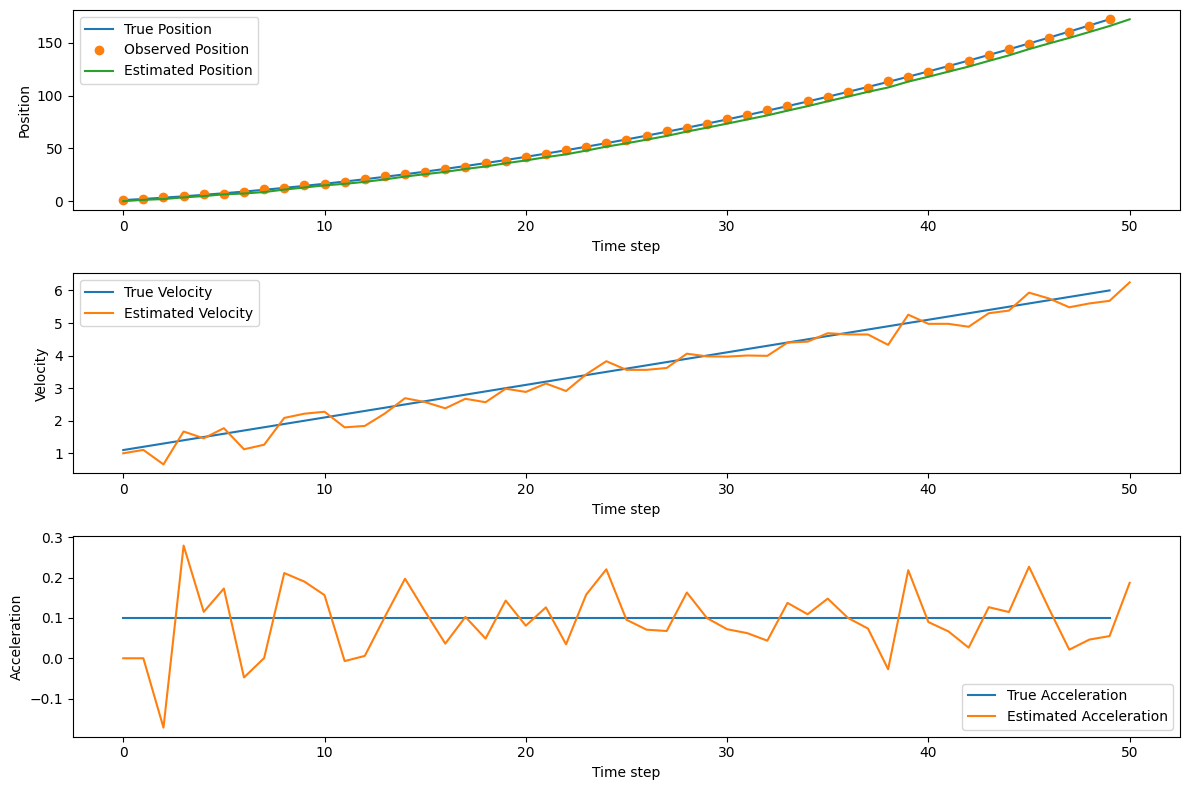

In [2]:
# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(range(T), true_states[:, 0], label='True Position')
plt.plot(range(T), observations, 'o', label='Observed Position')
plt.plot(range(T + 1), estimated_states[:, 0], label='Estimated Position')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(T), true_states[:, 1], label='True Velocity')
plt.plot(range(T + 1), estimated_states[:, 1], label='Estimated Velocity')
plt.xlabel('Time step')
plt.ylabel('Velocity')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(range(T), true_states[:, 2], label='True Acceleration')
plt.plot(range(T + 1), estimated_states[:, 2], label='Estimated Acceleration')
plt.xlabel('Time step')
plt.ylabel('Acceleration')
plt.legend()

plt.tight_layout()
plt.show()

## Reproduce the Song et al paper, i.e. using EKF on SEIRD model with all compartments data avaliable.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# SEIRD model
N = 1e6  # total population
alpha_true = 0.2  # latend period rate (real value)
beta_true = 0.5  # transmission rate (real value)
gamma_true = 0.1  # recovery rate (real value)
mu_true = 0.01  # death rate (real value)
dt = 1.0  # time step
T = 200  # number of time steps

# initial value
S0, E0, I0, R0, D0 = N - 1, 1, 0, 0, 0
x0 = np.array([[S0], [E0], [I0], [R0], [D0]])
state_dim = len(x0)
param_dim = 4  # beta, alpha, gamma, mu
total_dim = state_dim + param_dim  # total dim

# observation noise covariance matrix
RX = np.diag([10.0, 10.0])

# process noise covariance matrix
Q = np.eye(total_dim) * 0.5

# initial estimation noise covariance matrix
P = np.eye(total_dim)

# observation matrix
H = np.zeros((2, total_dim))
H[0, 2] = 1  # I
H[1, 4] = 1  # D

# intial value and parameter estimation
x_est = np.vstack((x0, np.array([[0.4], [0.2], [0.1], [0.01]])))


# add noise
def add_gaussian_noise(data, snr_db):
    snr = 10 ** (snr_db / 10.0)
    signal_power = np.mean(data ** 2)
    noise_power = signal_power / snr
    noise = np.sqrt(noise_power) * np.random.normal(size=data.shape)
    return data + noise

# generate new data
true_states = [x0.ravel()]
observed_I = []
observed_D = []
for t in range(T):
    S, E, I, R, D = true_states[-1]
    S_next = S - beta_true * S * I / N
    E_next = E + beta_true * S * I / N - alpha_true * E
    I_next = I + alpha_true * E - (gamma_true + mu_true) * I
    R_next = R + gamma_true * I
    D_next = D + mu_true * I
    next_state = np.array([S_next, E_next, I_next, R_next, D_next])
    true_states.append(next_state)
    observed_I.append(I_next + np.random.normal(0, np.sqrt(RX[0, 0])))
    observed_D.append(D_next + np.random.normal(0, np.sqrt(RX[1, 1])))

true_states = np.array(true_states)
observed_I = add_gaussian_noise(true_states[:, 2], 25)
observed_D = add_gaussian_noise(true_states[:, 4], 25)

# EKF
estimated_states = [x_est.ravel()]

for t in range(1, T + 1):
    # initial state
    S, E, I, R, D, beta, alpha, gamma, mu = x_est.ravel()

    # prediction
    S_next = S - beta * S * I / N
    E_next = E + beta * S * I / N - alpha * E
    I_next = I + alpha * E - (gamma + mu) * I
    R_next = R + gamma * I
    D_next = D + mu * I
    x_pred = np.array([[S_next], [E_next], [I_next], [R_next], [D_next], [beta], [alpha], [gamma], [mu]])

    # state transimission matrix
    F_t = np.eye(total_dim)
    F_t[0, 0] = 1 - beta * I / N
    F_t[0, 2] = -beta * S / N
    F_t[1, 0] = beta * I / N
    F_t[1, 1] = 1 - alpha
    F_t[1, 2] = beta * S / N
    F_t[2, 1] = alpha
    F_t[2, 2] = 1 - (gamma + mu)
    F_t[3, 2] = gamma
    F_t[4, 2] = mu

    P_pred = F_t @ P @ F_t.T + Q

    # update
    y = np.array([[observed_I[t - 1]], [observed_D[t - 1]]])
    S_y = H @ P_pred @ H.T + RX
    K = P_pred @ H.T @ np.linalg.inv(S_y)
    x_est = x_pred + K @ (y - H @ x_pred)
    P = (np.eye(total_dim) - K @ H) @ P_pred

    estimated_states.append(x_est.ravel())

estimated_states = np.array(estimated_states)


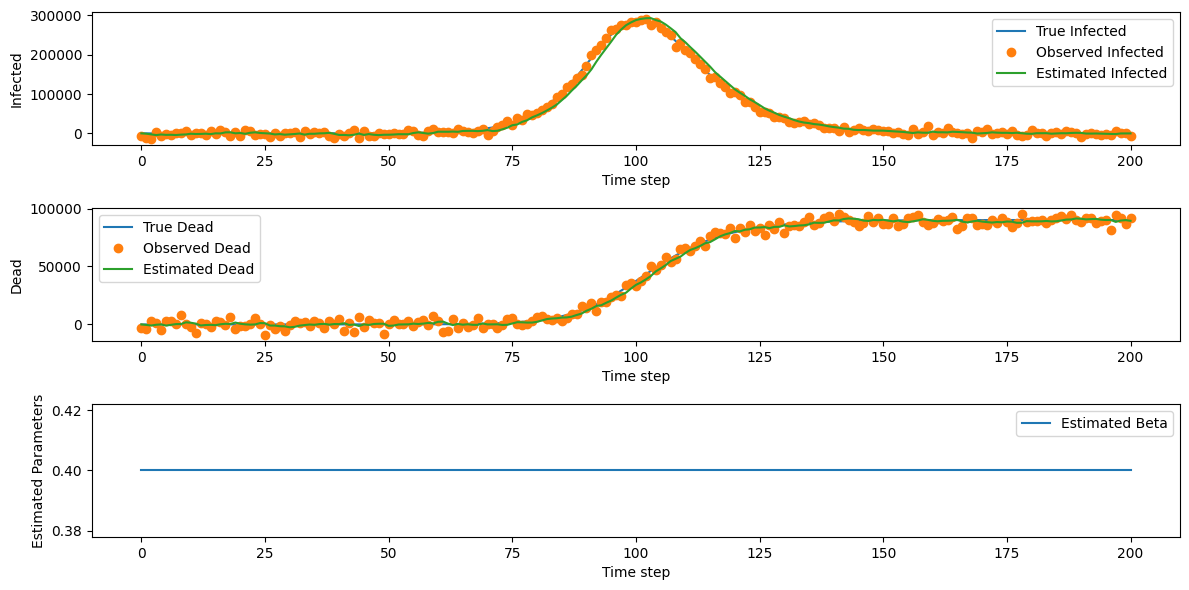

In [4]:
# visualization
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(range(T + 1), true_states[:, 2], label='True Infected')
plt.plot(range(T + 1), observed_I, 'o', label='Observed Infected')
plt.plot(range(T + 1), estimated_states[:, 2], label='Estimated Infected')
plt.xlabel('Time step')
plt.ylabel('Infected')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(T + 1), true_states[:, 4], label='True Dead')
plt.plot(range(T + 1), observed_D, 'o', label='Observed Dead')
plt.plot(range(T + 1), estimated_states[:, 4], label='Estimated Dead')
plt.xlabel('Time step')
plt.ylabel('Dead')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(range(T + 1), estimated_states[:, 5], label='Estimated Beta')
# plt.plot(range(T + 1), estimated_states[:, 6], label='Estimated Alpha')
# plt.plot(range(T + 1), estimated_states[:, 7], label='Estimated Gamma')
# plt.plot(range(T + 1), estimated_states[:, 8], label='Estimated Mu')
plt.xlabel('Time step')
plt.ylabel('Estimated Parameters')
plt.legend()

plt.tight_layout()
plt.show()

## using EKF on our SEIHR model

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# SEIHR model
N = 1  # total population
epsilon_true = 0.1  # rate of latend period that got infected
alpha_true = 0.2  # rate of have symptoms that got infected
beta_true = 0.5  # rate of transmission
gamma_true = 0.1  # rate of recovery
delta_E_true = 0.01  # rate of death of exposed people
delta_I_true = 0.01  # rate of death of infected people
delta_H_true = 0.01  # rate of death of hospitalized people
dt = 1.0  # time step
T = 150  # number of time steps

# initial state
S0, E0, I0, H0, R0 = N - 0.00001, 0.00001, 0, 0, 0
x0 = np.array([[S0], [E0], [I0], [H0], [R0]])
state_dim = len(x0)
param_dim = 7  # epsilon, alpha, beta, gamma, delta_E, delta_I, delta_H
total_dim = state_dim + param_dim  # total dim

# observation noise covariance matrix
RX = np.diag([10.0, 10.0, 10.0])

# process noise covariance matrix
Q = np.eye(total_dim) * 0.5

# initial estimation noise covariance matrix
P = np.eye(total_dim)

# observation matrix
HX = np.zeros((3, total_dim))
HX[0, 3] = 1  # H_n
HX[1, 2] = gamma_true  # I_n-1
HX[2, 3] = delta_H_true # H_n-1

# initial state and parameter estimation
x_est = np.vstack((x0, np.array([[0.08], [0.2], [0.5], [0.1], [0.01], [0.01], [0.01]])))  # 初始参数估计尽量接近真实值


# add noise
def add_gaussian_noise(data, snr_db):
    snr = 10 ** (snr_db / 10.0)
    signal_power = np.mean(data ** 2)
    noise_power = signal_power / snr
    noise = np.sqrt(noise_power) * np.random.normal(size=data.shape)
    return data + noise


true_states = [x0.ravel()]
observed_I = []
observed_H = []
for t in range(T):
    S, E, I, H, R = true_states[-1]
    S_next = S - (epsilon_true * E + alpha_true * I) * S
    E_next = E + (epsilon_true * E + alpha_true * I) * S - (beta_true + delta_E_true) * E
    I_next = I + beta_true * E - (gamma_true + delta_I_true) * I
    H_next = H + gamma_true * I - delta_H_true * H
    R_next = R + delta_E_true * E + delta_I_true * I + delta_H_true * H
    next_state = np.array([S_next, E_next, I_next, H_next, R_next])
    true_states.append(next_state)
    observed_I.append(I_next + np.random.normal(0, np.sqrt(RX[0, 0])))
    observed_H.append(H_next + np.random.normal(0, np.sqrt(RX[1, 1])))

true_states = np.array(true_states)
observed_I = add_gaussian_noise(true_states[:, 2], 25)
observed_H = add_gaussian_noise(true_states[:, 3], 25)

# EKF
estimated_states = [x_est.ravel()]

for t in range(1, T + 1):
    # initial state
    S, E, I, H, R, epsilon, alpha, beta, gamma, delta_E, delta_I, delta_H = x_est.ravel()

    # prediction
    S_next = S - (epsilon * E + alpha * I) * S
    E_next = E + (epsilon * E + alpha * I) * S - (beta + delta_E) * E
    I_next = I + beta * E - (gamma + delta_I) * I
    H_next = H + gamma * I - delta_H * H
    R_next = R + delta_E * E + delta_I * I + delta_H * H
    x_pred = np.array(
        [[S_next], [E_next], [I_next], [H_next], [R_next], [epsilon], [alpha], [beta], [gamma], [delta_E], [delta_I],
         [delta_H]])

    # state transimission matrix
    F_t = np.eye(total_dim)
    F_t[0, 1] = -epsilon * S
    F_t[0, 2] = -alpha * S
    F_t[1, 0] = epsilon * E + alpha * I
    F_t[1, 1] = epsilon * S - (beta + delta_E)
    F_t[1, 2] = alpha * S
    F_t[2, 1] = beta
    F_t[2, 2] = - (gamma + delta_I)
    F_t[3, 2] = gamma
    F_t[3, 3] = -delta_H
    F_t[4, 1] = delta_E
    F_t[4, 2] = delta_I
    F_t[4, 3] = delta_H

    P_pred = F_t @ P @ F_t.T + Q

    # update
    y = np.array([[observed_H[t]],[gamma_true*observed_I[t-1]], [delta_H_true*observed_H[t - 1]]])
    S_y = HX @ P_pred @ HX.T + RX
    K = P_pred @ HX.T @ np.linalg.inv(S_y)
    x_est = x_pred + K @ (y - HX @ x_pred)
    P = (np.eye(total_dim) - K @ HX) @ P_pred

    estimated_states.append(x_est.ravel())

estimated_states = np.array(estimated_states)


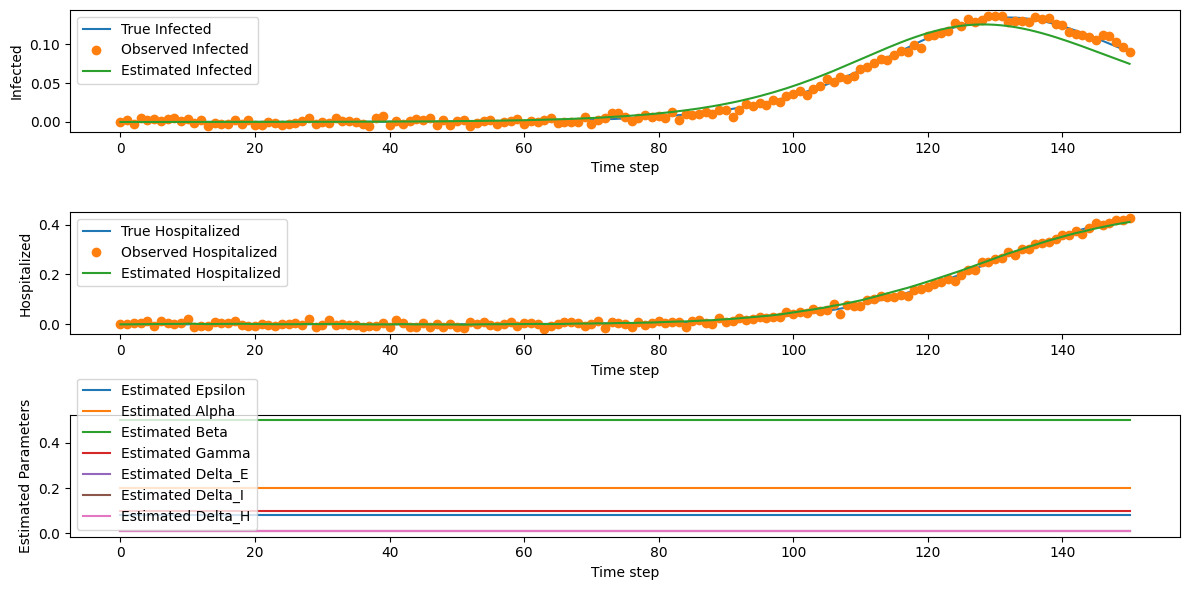

In [6]:
# visualization
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(range(T + 1), true_states[:, 2], label='True Infected')
plt.plot(range(T + 1), observed_I, 'o', label='Observed Infected')
plt.plot(range(T + 1), estimated_states[:, 2], label='Estimated Infected')
plt.xlabel('Time step')
plt.ylabel('Infected')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(T + 1), true_states[:, 3], label='True Hospitalized')
plt.plot(range(T + 1), observed_H, 'o', label='Observed Hospitalized')
plt.plot(range(T + 1), estimated_states[:, 3], label='Estimated Hospitalized')
plt.xlabel('Time step')
plt.ylabel('Hospitalized')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(range(T + 1), estimated_states[:, 5], label='Estimated Epsilon')
plt.plot(range(T + 1), estimated_states[:, 6], label='Estimated Alpha')
plt.plot(range(T + 1), estimated_states[:, 7], label='Estimated Beta')
plt.plot(range(T + 1), estimated_states[:, 8], label='Estimated Gamma')
plt.plot(range(T + 1), estimated_states[:, 9], label='Estimated Delta_E')
plt.plot(range(T + 1), estimated_states[:, 10], label='Estimated Delta_I')
plt.plot(range(T + 1), estimated_states[:, 11], label='Estimated Delta_H')
plt.xlabel('Time step')
plt.ylabel('Estimated Parameters')
plt.legend()

plt.tight_layout()
plt.show()